INFO:ml_toolbox.data_loader.data_loader:Loading 2 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 2 files


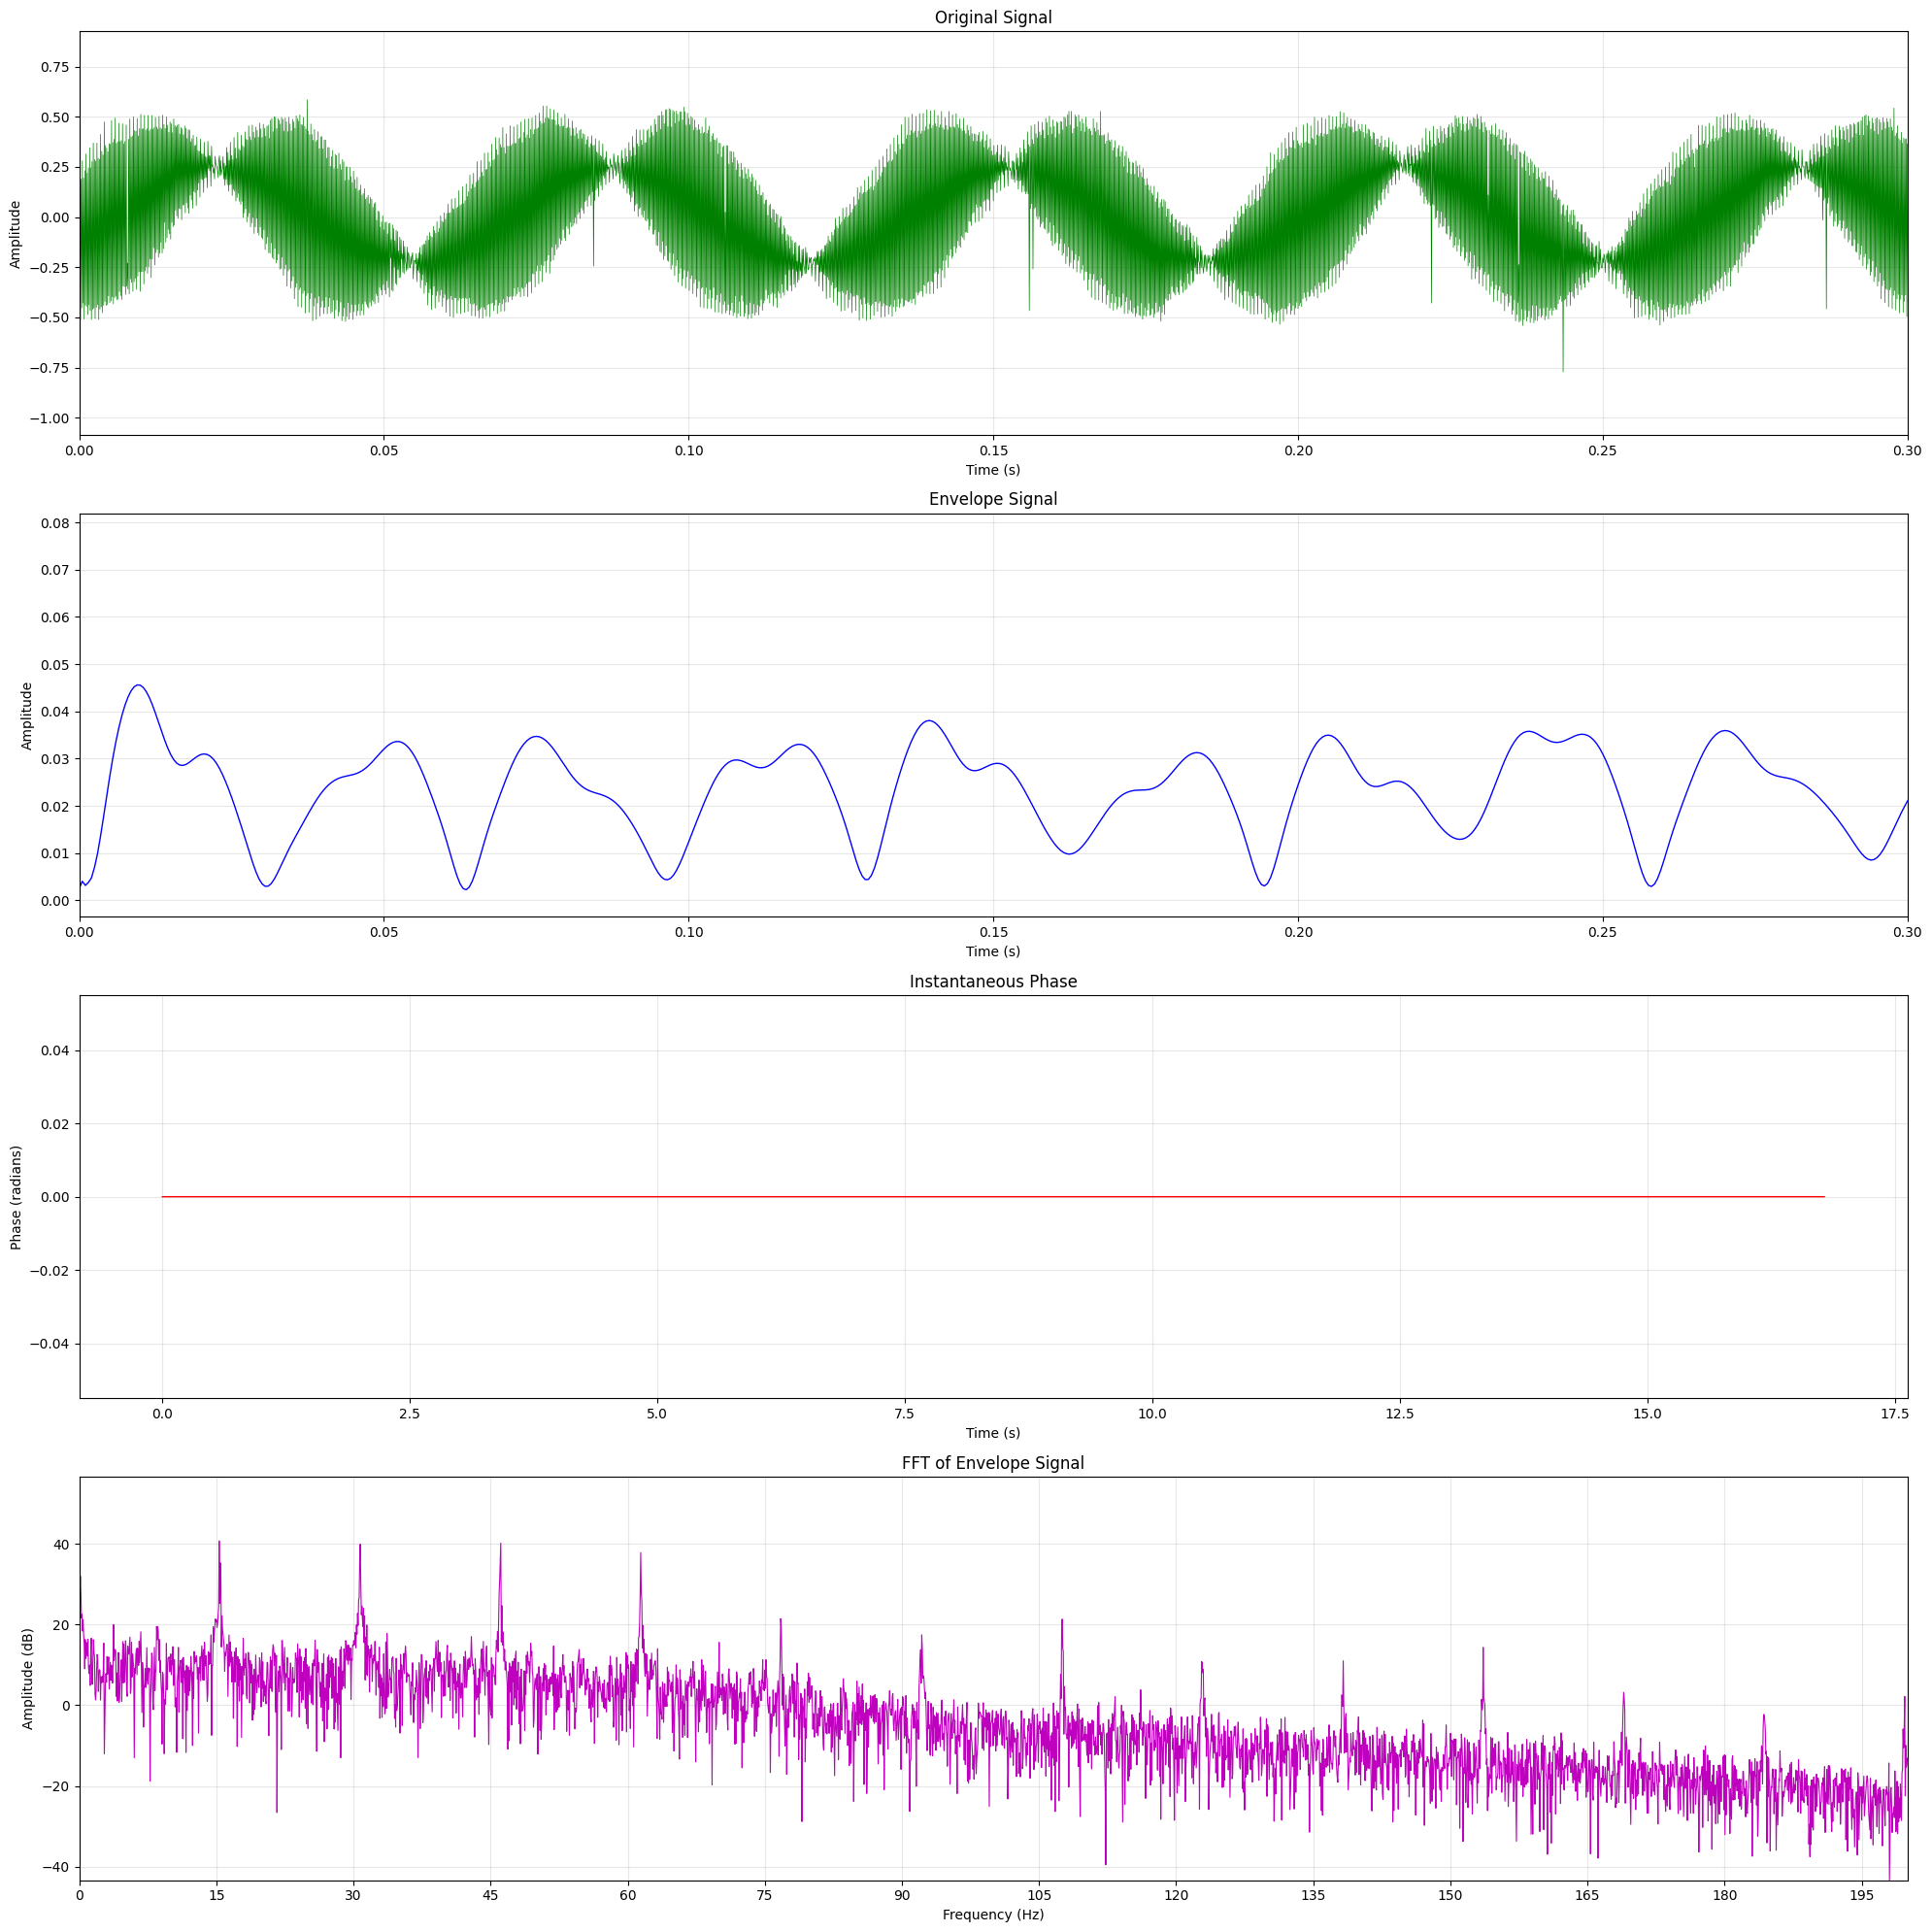

Original sampling frequency: 10000 Hz
Envelope sampling frequency: 2000.0 Hz
Signal duration: 16.79 seconds
Original signal range: -0.9946 to 0.8338
Envelope amplitude range: 0.0004 to 0.0781
Phase range: 0.00 to 0.00 radians

Top 5 peak frequencies in envelope FFT:
  0.00 Hz: 56.68 dB
  15.31 Hz: 40.78 dB
  46.11 Hz: 40.24 dB
  30.74 Hz: 39.98 dB
  61.42 Hz: 37.87 dB


In [1]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '30hz'
sensor_type = 'current'
load = 'under_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)
n_idx = 0
n_healthy = int (healthy[n_idx].shape[0] / 1)

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[n_idx], healthy_metadata[n_idx])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

# carrier freqs: 1670, 3330
carrier_freq = 3330
env_conf = EnvelopeConfig(
    bandpass_low=carrier_freq - 50,
    bandpass_high=carrier_freq + 50,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)

import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

fig, axs = plt.subplots(4, 1, figsize=(20, 20))

orig = stages['original']
from scipy.signal import hilbert
env = stages['envelope_decimated']
inst_phase = np.unwrap(np.angle(env))

ts_orig = env_conf.sampling_rate
ts_env = env_conf.envelope_fs
t_orig = np.arange(len(orig)) / ts_orig
t_env = np.arange(len(env)) / ts_env

# Plot original signal
axs[0].plot(t_orig, orig, 'g-', linewidth=0.5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].set_xlim([0, 0.3])
axs[0].grid(True, alpha=0.3)

# Plot envelope
axs[1].plot(t_env, env, 'b-', linewidth=1)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Envelope Signal')
axs[1].set_xlim([0, 0.3])
axs[1].grid(True, alpha=0.3)

# Plot instantaneous phase
axs[2].plot(t_env, inst_phase, 'r-', linewidth=1)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Phase (radians)')
axs[2].set_title('Instantaneous Phase')
axs[2].grid(True, alpha=0.3)

# Compute and plot FFT of envelope
fft_env = fft(np.abs(env))
freqs_env = fftfreq(len(env), 1/ts_env)

# Get positive frequencies only
positive_freq_idx = freqs_env >= 0
freqs_env_pos = freqs_env[positive_freq_idx]
fft_env_pos = np.abs(fft_env[positive_freq_idx])

# Convert to dB
fft_env_db = 20 * np.log10(fft_env_pos + 1e-10)

# Plot FFT of envelope
xlim_env = 200
xlim_mask = freqs_env_pos <= xlim_env
freqs_env_cropped = freqs_env_pos[xlim_mask]
fft_env_cropped = fft_env_db[xlim_mask]

axs[3].plot(freqs_env_cropped, fft_env_cropped, 'm-', linewidth=0.8)
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Amplitude (dB)')
axs[3].set_title('FFT of Envelope Signal')
axs[3].grid(True, alpha=0.3)
axs[3].set_xlim(0, xlim_env)
axs[3].set_ylim(min(fft_env_cropped), max(fft_env_cropped))
axs[3].set_xticks(np.arange(0, xlim_env + 1, 15))

plt.tight_layout()
plt.show()

# Print some basic info
print(f"Original sampling frequency: {ts_orig} Hz")
print(f"Envelope sampling frequency: {ts_env} Hz")
print(f"Signal duration: {len(env)/ts_env:.2f} seconds")
print(f"Original signal range: {np.min(orig):.4f} to {np.max(orig):.4f}")
print(f"Envelope amplitude range: {np.min(np.abs(env)):.4f} to {np.max(np.abs(env)):.4f}")
print(f"Phase range: {np.min(inst_phase):.2f} to {np.max(inst_phase):.2f} radians")

# Print peak frequencies in envelope FFT
print("\nTop 5 peak frequencies in envelope FFT:")
peak_indices = np.argsort(fft_env_pos)[-5:][::-1]
for idx in peak_indices:
    print(f"  {freqs_env_pos[idx]:.2f} Hz: {fft_env_db[idx]:.2f} dB")

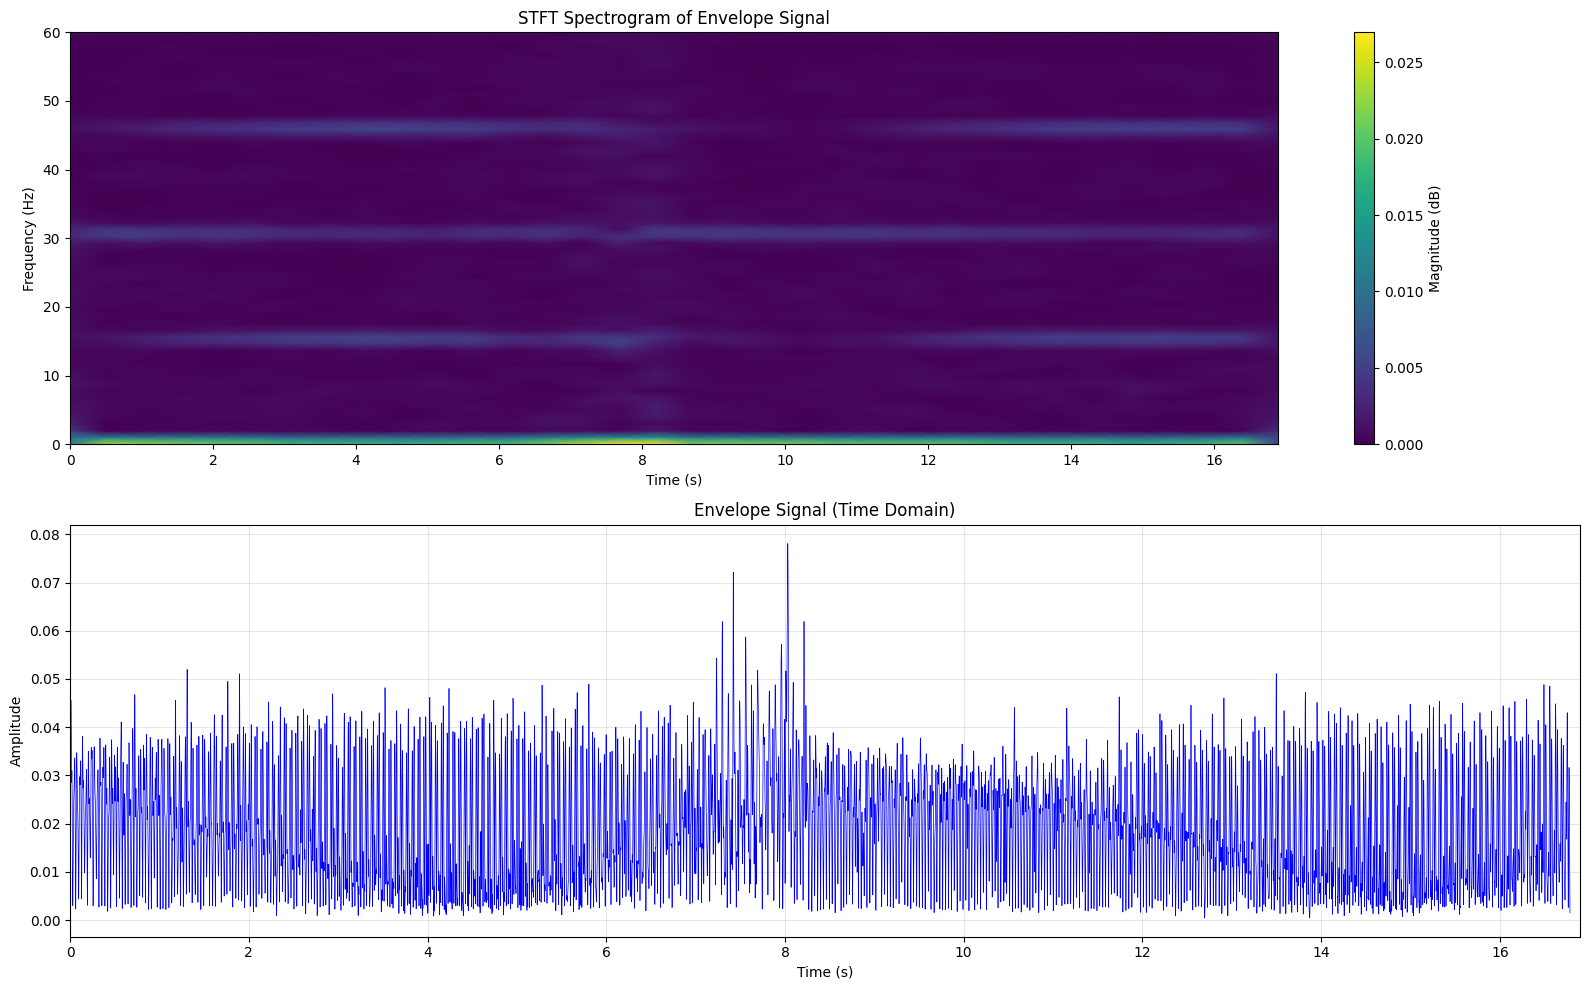

STFT Parameters:
  Window length (nperseg): 2048
  Overlap: 1024 samples (50%)
  Frequency resolution: 0.98 Hz
  Time resolution: 0.5120 s
  Frequency range: 0.00 to 1000.00 Hz
  Time range: 0.0000 to 16.8960 s


In [2]:
# STFT Analysis of Envelope Signal
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np

# Compute STFT of the envelope
# Using shorter window for better time resolution in envelope analysis
nperseg = 2048  # Window length
noverlap = nperseg // 2  # 50% overlap

f_stft, t_stft, Zxx = stft(np.abs(env), fs=ts_env, nperseg=nperseg, noverlap=noverlap)

# Convert to dB scale
Zxx_db = 20 * np.log10(np.abs(Zxx) + 1e-10)

# Create figure with STFT spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Spectrogram
pcm = ax1.pcolormesh(t_stft, f_stft, np.abs(Zxx), shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('STFT Spectrogram of Envelope Signal')
ax1.set_ylim(0, 60)  # Focus on 0-60 Hz range
fig.colorbar(pcm, ax=ax1, label='Magnitude (dB)')

# Plot 2: Time-domain envelope for reference
ax2.plot(t_env, np.abs(env), 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Envelope Signal (Time Domain)')
ax2.set_xlim(t_stft[0], t_stft[-1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"STFT Parameters:")
print(f"  Window length (nperseg): {nperseg}")
print(f"  Overlap: {noverlap} samples ({100*noverlap/nperseg:.0f}%)")
print(f"  Frequency resolution: {f_stft[1] - f_stft[0]:.2f} Hz")
print(f"  Time resolution: {t_stft[1] - t_stft[0]:.4f} s")
print(f"  Frequency range: {f_stft[0]:.2f} to {f_stft[-1]:.2f} Hz")
print(f"  Time range: {t_stft[0]:.4f} to {t_stft[-1]:.4f} s")

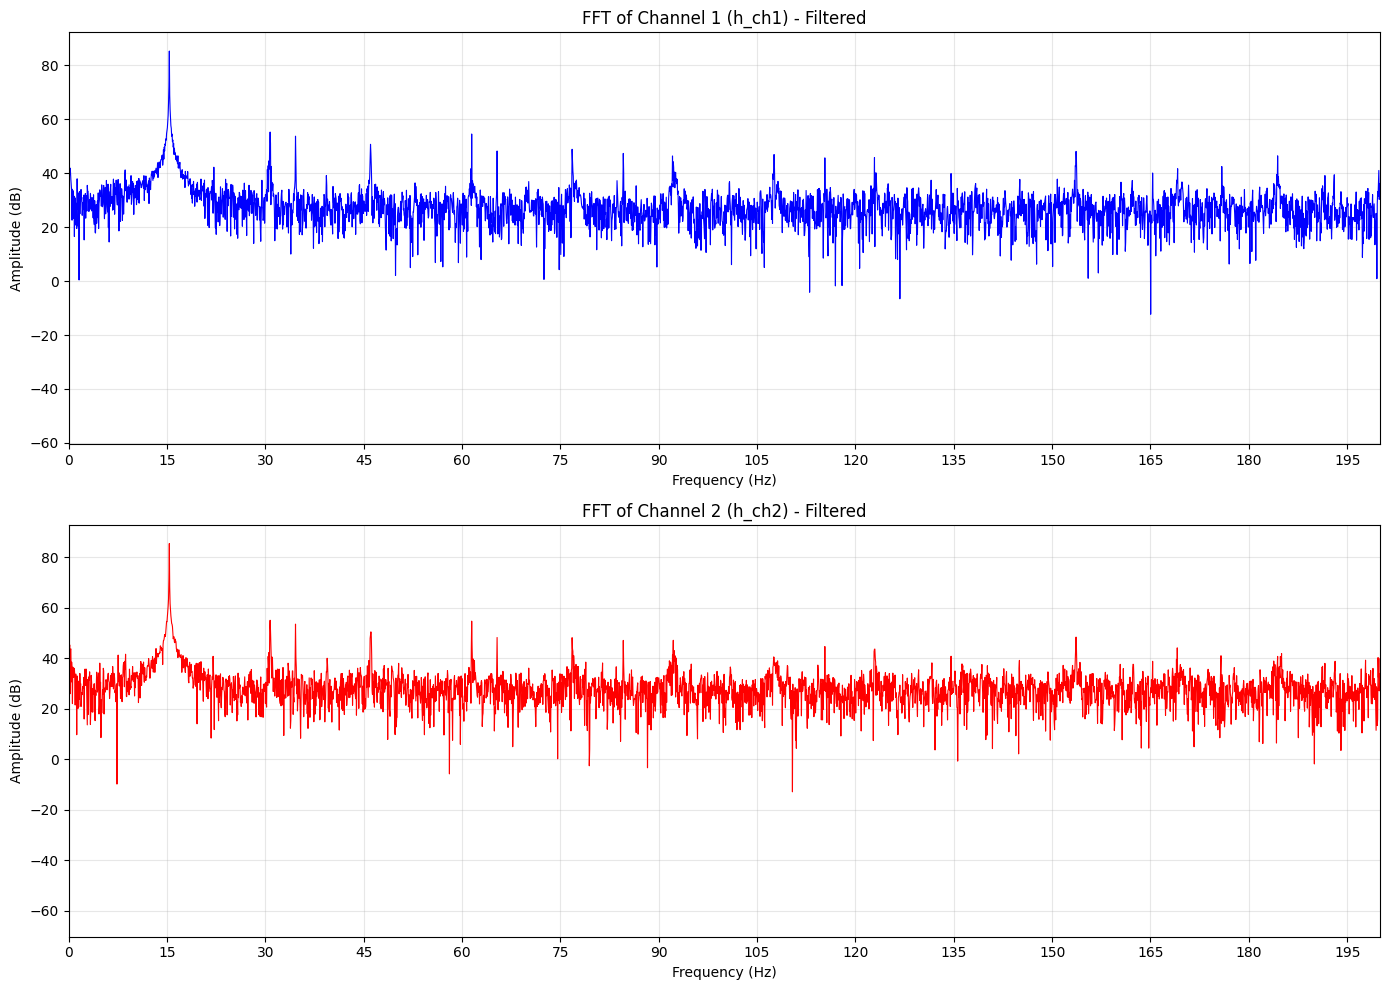


Amplitudes at specific frequencies:
Frequency (Hz)       Ch1 Amp (dB)              Ch2 Amp (dB)             
----------------------------------------------------------------------
30.03                32.09                     22.13                    
59.99                26.67                     24.67                    
90.02                26.36                     32.29                    
119.99               31.40                     28.13                    
150.01               19.72                     27.24                    
179.98               27.56                     27.08                    


In [3]:
# FFT Analysis of h_ch1 and h_ch2
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt, butter, filtfilt

# Apply filtering to both channels
nyquist = sampling_rate / 2
normal_cutoff = 3500 / nyquist
b, a = butter(4, normal_cutoff, btype='low', analog=False)

# Step 1: Apply median filter for despiking
h_ch1_despiked = medfilt(h_ch1, kernel_size=7)
h_ch2_despiked = medfilt(h_ch2, kernel_size=7)

# Step 2: Apply Butterworth lowpass filter with zero-phase filtering
h_ch1_filtered = filtfilt(b, a, h_ch1_despiked)
h_ch2_filtered = filtfilt(b, a, h_ch2_despiked)

# Compute FFT for both filtered channels
fft_ch1 = fft(h_ch1_filtered)
fft_ch2 = fft(h_ch2_filtered)

# Frequency bins
freqs = fftfreq(len(h_ch1_filtered), 1/sampling_rate)

# Get positive frequencies only
positive_freq_idx = freqs >= 0
freqs_pos = freqs[positive_freq_idx]
fft_ch1_pos = np.abs(fft_ch1[positive_freq_idx])
fft_ch2_pos = np.abs(fft_ch2[positive_freq_idx])

# Convert to dB
fft_ch1_db = 20 * np.log10(fft_ch1_pos + 1e-10)  # Add small value to avoid log(0)
fft_ch2_db = 20 * np.log10(fft_ch2_pos + 1e-10)

# Plot FFT with dB scale on y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(freqs_pos, fft_ch1_db, 'b-', linewidth=0.8)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (dB)')
ax1.set_title('FFT of Channel 1 (h_ch1) - Filtered')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 200)
ax1.set_xticks(np.arange(0, 201, 15))

ax2.plot(freqs_pos, fft_ch2_db, 'r-', linewidth=0.8)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude (dB)')
ax2.set_title('FFT of Channel 2 (h_ch2) - Filtered')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 200)
ax2.set_xticks(np.arange(0, 201, 15))

plt.tight_layout()
plt.show()

# Print amplitudes at specific frequencies
target_freqs = [30, 60, 90, 120, 150, 180]
print("\nAmplitudes at specific frequencies:")
print("=" * 70)
print(f"{'Frequency (Hz)':<20} {'Ch1 Amp (dB)':<25} {'Ch2 Amp (dB)':<25}")
print("-" * 70)

for target_freq in target_freqs:
    # Find closest frequency bin
    idx = np.argmin(np.abs(freqs_pos - target_freq))
    actual_freq = freqs_pos[idx]
    amp_ch1_db = 20 * np.log10(fft_ch1_pos[idx] + 1e-10)
    amp_ch2_db = 20 * np.log10(fft_ch2_pos[idx] + 1e-10)
    print(f"{actual_freq:<20.2f} {amp_ch1_db:<25.2f} {amp_ch2_db:<25.2f}")


INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 2 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 2 files


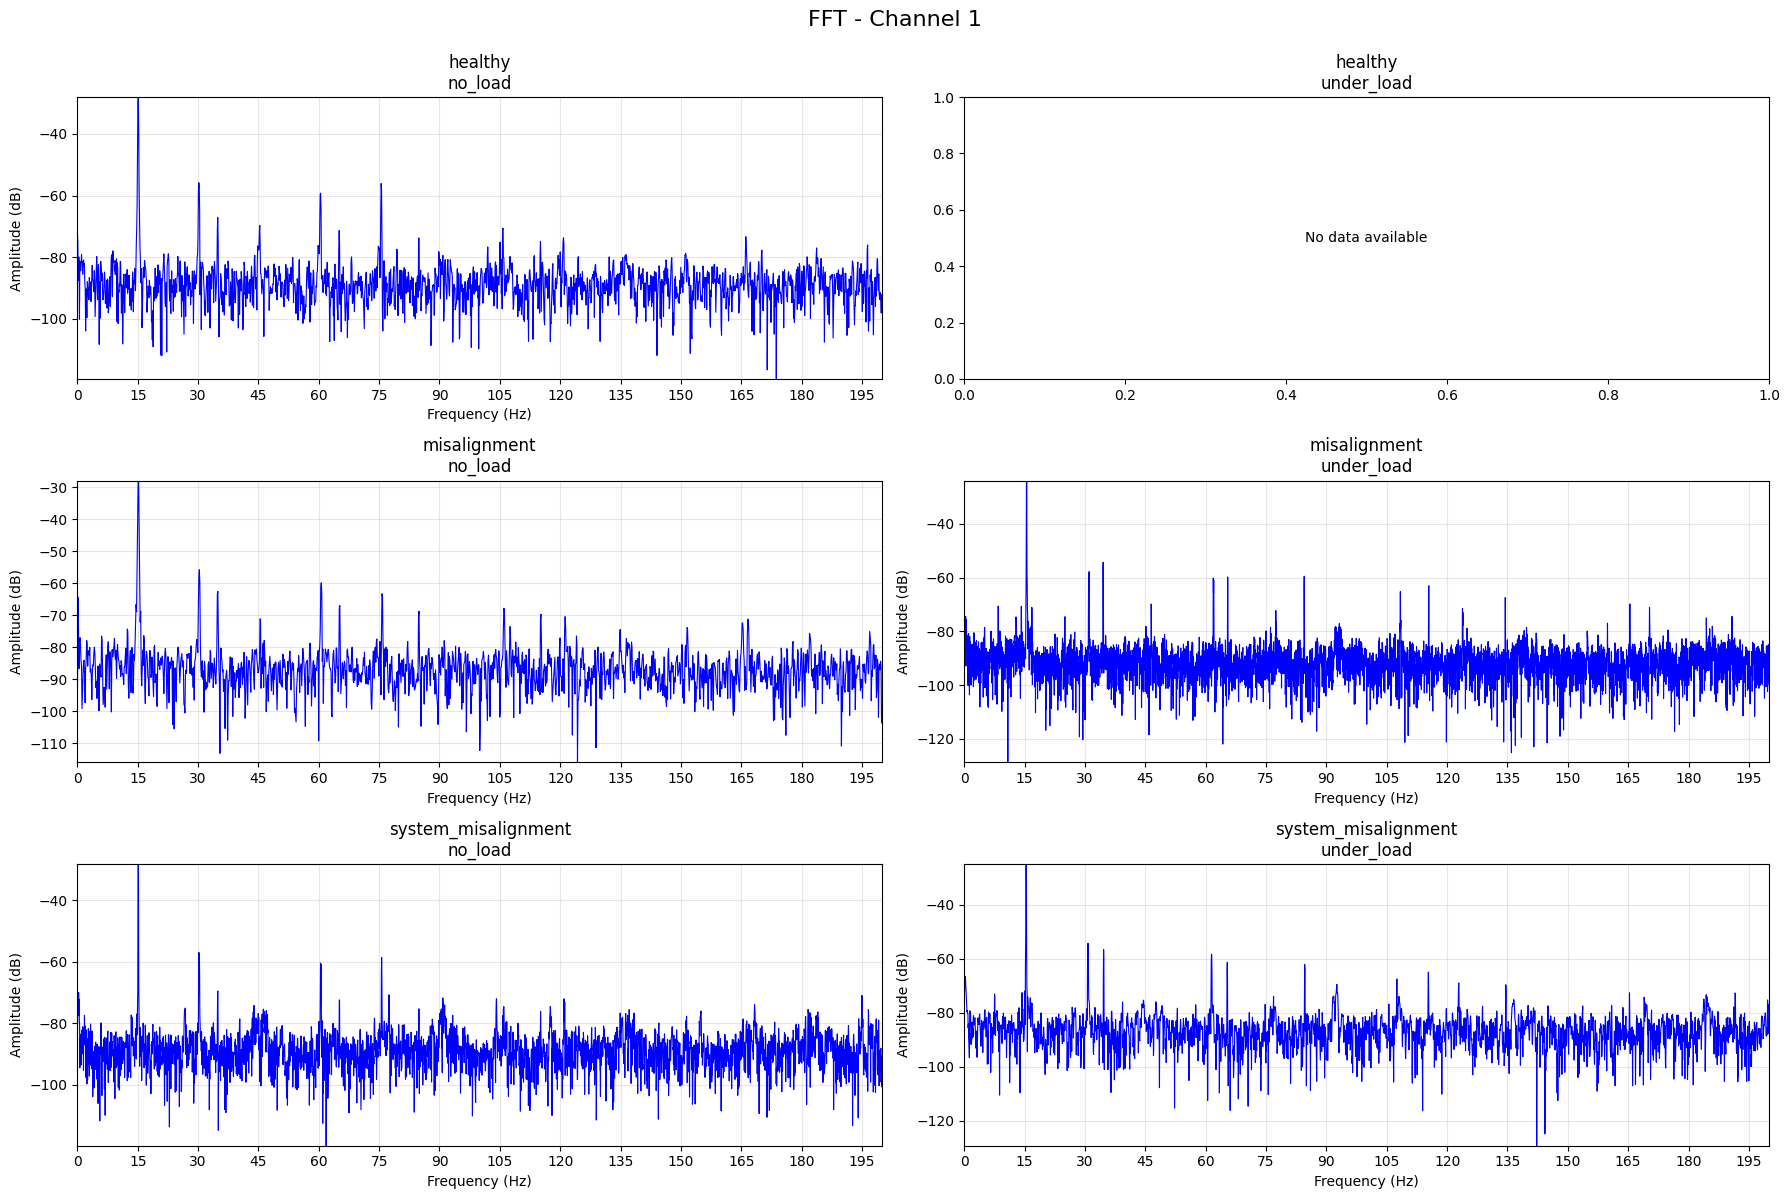

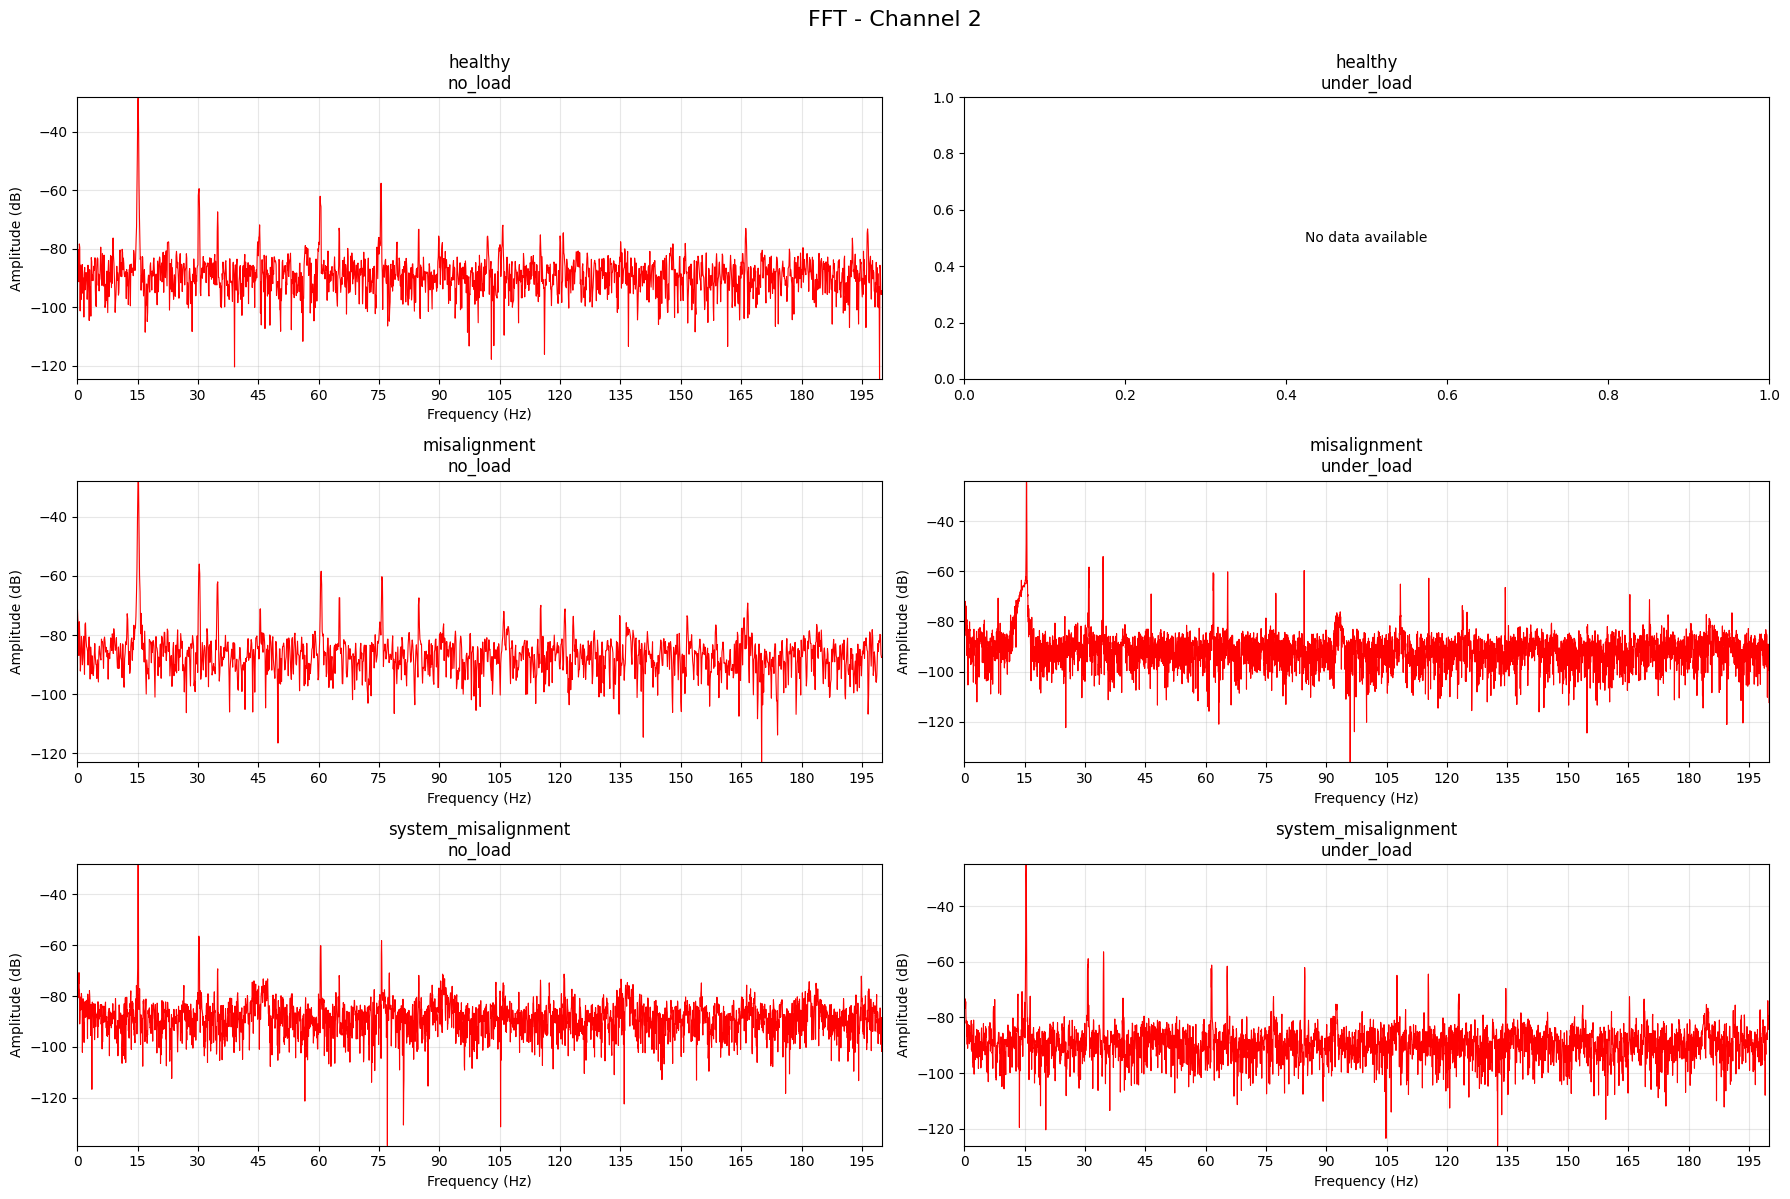


Summary of Peak Amplitudes:
          condition       load  target_freq  peak_freq_ch1  peak_amp_ch1_linear  peak_freq_ch2  peak_amp_ch2_linear
            healthy    no_load           15      15.140820             0.039436      15.140820             0.038694
            healthy    no_load           30      30.179337             0.001616      30.281640             0.001058
            healthy    no_load           60      60.460977             0.001094      60.358674             0.000785
            healthy    no_load           90      89.821891             0.000123      89.821891             0.000164
            healthy    no_load          120     120.819650             0.000207     120.819650             0.000187
            healthy    no_load          150     151.203593             0.000115     151.101290             0.000123
            healthy    no_load          180     183.735895             0.000142     180.359901             0.000104
       misalignment    no_load           15

In [ ]:
# Comprehensive FFT Analysis across all conditions and loads
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt, butter, filtfilt, find_peaks, windows

# Define conditions and loads to analyze
conditions = ['healthy', 'misalignment', 'system_misalignment']
loads = ['no_load', 'under_load']
frequency = '30hz'
target_freqs = [15, 30, 60, 90, 120, 150, 180]
file_idx = 0
xlimval = 200
do_db = True

# Filter setup
sampling_rate = 10000
nyquist = sampling_rate / 2
normal_cutoff = 3500 / nyquist
b, a = butter(4, normal_cutoff, btype='low', analog=False)

def apply_filter(signal):
    """Apply median filter and butterworth lowpass filter"""
    despiked = medfilt(signal, kernel_size=21)
    filtered = filtfilt(b, a, despiked)
    return filtered

def compute_fft_matlab_style(signal, are_u_sure=False):
    """
    Compute FFT with Hann window and MATLAB-style one-sided spectrum normalization.
    Equivalent to MATLAB:
        P2 = abs(fft_result(1:floor(N/2)+1));
        P2(2:end-1) = 2 * P2(2:end-1);
    """
    N = len(signal)
    hann_window = windows.hann(N)
    if are_u_sure:
        # Apply Hann window
        windowed_signal = signal * hann_window

        # Compute FFT with normalization by N 
        fft_result = fft(windowed_signal) / N

        # Get one-sided spectrum (from 0 to Nyquist)
        n_oneside = N // 2 + 1
        fft_oneside = np.abs(fft_result[:n_oneside])

        # MATLAB-style normalization: multiply by 2 except DC (index 0) and Nyquist (last index)
        fft_oneside[1:-1] = 2 * fft_oneside[1:-1]

        # Frequency bins for one-sided spectrum
        freqs_oneside = np.arange(n_oneside) * (sampling_rate / N)
    else:
        
        windowed_signal = signal * hann_window
        fft_ch1 = fft(windowed_signal) / N

        # Frequency bins
        freqs_oneside = fftfreq(len(signal), 1/sampling_rate)

        # Get positive frequencies only
        positive_freq_idx = freqs_oneside >= 0
        freqs_oneside = freqs_oneside[positive_freq_idx]
        fft_oneside = np.abs(fft_ch1[positive_freq_idx])
    
    return freqs_oneside, fft_oneside

def find_peak_amplitude(freqs, fft_linear, fft_db, target_freq, search_window=5):
    """Find peak amplitude near target frequency, return both linear and dB"""
    # Define search range around target frequency
    search_mask = (freqs >= target_freq - search_window) & (freqs <= target_freq + search_window)
    search_freqs = freqs[search_mask]
    search_amps_db = fft_db[search_mask]
    search_amps_linear = fft_linear[search_mask]
    
    if len(search_amps_db) == 0:
        return target_freq, np.nan, np.nan
    
    # Find peaks in the search window (using dB for peak detection)
    peaks, _ = find_peaks(search_amps_db, height=None)
    
    if len(peaks) > 0:
        # Get the highest peak
        max_peak_idx = peaks[np.argmax(search_amps_db[peaks])]
        peak_freq = search_freqs[max_peak_idx]
        peak_amp_db = search_amps_db[max_peak_idx]
        peak_amp_linear = search_amps_linear[max_peak_idx]
    else:
        # No peaks found, use maximum value in window
        max_idx = np.argmax(search_amps_db)
        peak_freq = search_freqs[max_idx]
        peak_amp_db = search_amps_db[max_idx]
        peak_amp_linear = search_amps_linear[max_idx]
    
    return peak_freq, peak_amp_linear, peak_amp_db

# Storage for results
results = []

# Create figures for both channels
n_conditions = len(conditions)
n_loads = len(loads)

fig1, axes1 = plt.subplots(n_conditions, n_loads, figsize=(18, 12))
fig1.suptitle('FFT - Channel 1', fontsize=16, y=0.995)

fig2, axes2 = plt.subplots(n_conditions, n_loads, figsize=(18, 12))
fig2.suptitle('FFT - Channel 2', fontsize=16, y=0.995)

# Process each condition and load
for i, condition in enumerate(conditions):
    for j, load in enumerate(loads):
        try:
            # Load data
            data, metadata = data_loader.load_batch(
                condition=condition,
                load=load,
                sensor_type=sensor_type,
                frequency=frequency,
                apply_filter=False,
                max_workers=1
            )
            
            if len(data) == 0:
                axes1[i, j].text(0.5, 0.5, 'No data available', 
                               ha='center', va='center', transform=axes1[i, j].transAxes)
                axes1[i, j].set_title(f'{condition}\n{load}')
                axes2[i, j].text(0.5, 0.5, 'No data available', 
                               ha='center', va='center', transform=axes2[i, j].transAxes)
                axes2[i, j].set_title(f'{condition}\n{load}')
                continue
            
            # Extract first sample
            sample = data[file_idx]
            sample_meta = metadata[file_idx]
            
            # Extract windows
            window_config = WindowConfig(
                window_size=sample.shape[0],
                step_size=int(sample.shape[0] * 0.5),
                overlap_ratio=0.5
            )
            extractor = WindowExtractor(window_config)
            windows_data, _ = extractor.extract_windows(sample, sample_meta)
            
            # Get first window
            window = windows_data[0]
            ch1 = window[:, 0]
            ch2 = window[:, 1]
            
            # Apply filtering
            #ch1 = apply_filter(ch1)
            #ch2 = apply_filter(ch2)
            
            # Compute FFT with Hann window and MATLAB-style normalization
            freqs_pos, fft_ch1_pos = compute_fft_matlab_style(ch1)
            _, fft_ch2_pos = compute_fft_matlab_style(ch2)
            
            fft_ch1_db = fft_ch1_pos
            fft_ch2_db = fft_ch2_pos
            # Convert to dB
            if do_db:
                fft_ch1_db = 20 * np.log10(fft_ch1_pos + 1e-10)
                fft_ch2_db = 20 * np.log10(fft_ch2_pos + 1e-10)

            # Crop arrays to xlimval for better y-axis scaling
            xlim_mask = freqs_pos <= xlimval
            freqs_cropped = freqs_pos[xlim_mask]
            fft_ch1_cropped = fft_ch1_db[xlim_mask]
            fft_ch2_cropped = fft_ch2_db[xlim_mask]

            # Plot FFT for Channel 1
            axes1[i, j].plot(freqs_cropped, fft_ch1_cropped, 'b-', linewidth=0.8)
            axes1[i, j].set_xlabel('Frequency (Hz)')
            axes1[i, j].set_ylabel('Amplitude (dB)')
            axes1[i, j].set_title(f'{condition}\n{load}')
            axes1[i, j].grid(True, alpha=0.3)
            axes1[i, j].set_xlim(0, xlimval)
            axes1[i, j].set_ylim(min(fft_ch1_cropped), max(fft_ch1_cropped))
            axes1[i, j].set_xticks(np.arange(0, xlimval + 1, 15))
            
            # Plot FFT for Channel 2
            axes2[i, j].plot(freqs_cropped, fft_ch2_cropped, 'r-', linewidth=0.8)
            axes2[i, j].set_xlabel('Frequency (Hz)')
            axes2[i, j].set_ylabel('Amplitude (dB)')
            axes2[i, j].set_title(f'{condition}\n{load}')
            axes2[i, j].grid(True, alpha=0.3)
            axes2[i, j].set_xlim(0, xlimval)
            axes2[i, j].set_ylim(min(fft_ch2_cropped), max(fft_ch2_cropped))
            axes2[i, j].set_xticks(np.arange(0, xlimval + 1, 15))
            
            # Find peak amplitudes at target frequencies
            for target_freq in target_freqs:
                peak_freq_ch1, peak_amp_ch1_lin, peak_amp_ch1_db = find_peak_amplitude(
                    freqs_pos, fft_ch1_pos, fft_ch1_db, target_freq)
                peak_freq_ch2, peak_amp_ch2_lin, peak_amp_ch2_db = find_peak_amplitude(
                    freqs_pos, fft_ch2_pos, fft_ch2_db, target_freq)
                
                # Store results
                results.append({
                    'condition': condition,
                    'load': load,
                    'target_freq': target_freq,
                    'peak_freq_ch1': peak_freq_ch1,
                    'peak_amp_ch1_linear': peak_amp_ch1_lin,
                    'peak_freq_ch2': peak_freq_ch2,
                    'peak_amp_ch2_linear': peak_amp_ch2_lin,
                })
            
        except Exception as e:
            axes1[i, j].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                           ha='center', va='center', transform=axes1[i, j].transAxes)
            axes1[i, j].set_title(f'{condition}\n{load}')
            axes2[i, j].text(0.5, 0.5, f'Error: {str(e)[:30]}...', 
                           ha='center', va='center', transform=axes2[i, j].transAxes)
            axes2[i, j].set_title(f'{condition}\n{load}')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# Create summary DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of Peak Amplitudes:")
print("="*150)
print(results_df.to_string(index=False))

# Export to Excel
output_path = Path("../reports/peak_amplitudes_summary.xlsx")
output_path.parent.mkdir(parents=True, exist_ok=True)
results_df.to_excel(output_path, index=False, sheet_name='Peak Amplitudes')
